# 10. Logistic Regression

## 10.4 Robust logistic regression

### 10.4.1 Mixture model for the likelihood

> Robust Bayesian Binary logistic regression in 1d for iris flowers
>
> Code is based on
> https://github.com/aloctavodia/BAP/blob/master/code/Chp4/04_Generalizing_linear_models.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data, iris.target
X.shape, y.shape

((150, 4), (150,))

In [3]:
# Convert to pandas dataframe
df_iris = pd.DataFrame(data=X, columns=iris.feature_names) #iris.target_names
df_iris['species'] = pd.Series(iris.target_names[y], dtype='category')
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
# Create inliers
_df = df_iris[(df_iris['species'] == 'setosa') | (df_iris['species'] == 'versicolor')]
x_inliers = _df['sepal length (cm)'].to_numpy()  # sepal length (cm)
y_inliers = pd.Categorical(_df['species']).codes # species (0: setosa, 1: versicolor)
n_inliers = len(x_inliers)
x_inliers, y_inliers, n_inliers

(array([5.1, 4.9, 4.7, 4.6, 5. , 5.4, 4.6, 5. , 4.4, 4.9, 5.4, 4.8, 4.8,
        4.3, 5.8, 5.7, 5.4, 5.1, 5.7, 5.1, 5.4, 5.1, 4.6, 5.1, 4.8, 5. ,
        5. , 5.2, 5.2, 4.7, 4.8, 5.4, 5.2, 5.5, 4.9, 5. , 5.5, 4.9, 4.4,
        5.1, 5. , 4.5, 4.4, 5. , 5.1, 4.8, 5.1, 4.6, 5.3, 5. , 7. , 6.4,
        6.9, 5.5, 6.5, 5.7, 6.3, 4.9, 6.6, 5.2, 5. , 5.9, 6. , 6.1, 5.6,
        6.7, 5.6, 5.8, 6.2, 5.6, 5.9, 6.1, 6.3, 6.1, 6.4, 6.6, 6.8, 6.7,
        6. , 5.7, 5.5, 5.5, 5.8, 6. , 5.4, 6. , 6.7, 6.3, 5.6, 5.5, 5.5,
        6.1, 5.8, 5. , 5.6, 5.7, 5.7, 6.2, 5.1, 5.7]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int8),
 100)

In [5]:
# Create outliers
x_outliers = np.array([4.2, 4.5, 4.0, 4.3, 4.2, 4.4])
y_outliers = np.ones_like(x_outliers, dtype='int8') # 1: versicolor
n_outliers = len(x_outliers)
x_outliers, y_outliers, n_outliers

(array([4.2, 4.5, 4. , 4.3, 4.2, 4.4]),
 array([1, 1, 1, 1, 1, 1], dtype=int8),
 6)

In [6]:
import pymc as pm
import arviz as az

def infer_nonrobust_model(x_c, y_0):
    with pm.Model() as model_0:
        w = pm.Normal('w', mu=0, sigma=10)
        β = pm.Normal('β', mu=0, sigma=10)
        μ = pm.math.dot(w, x_c) + β

        θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
        bd = pm.Deterministic('bd', -β / w) # decision boundary

        yl = pm.Bernoulli('yl', p=θ, observed=y_0)

        trace = pm.sample(1000, cores=1, chains=2)

    varnames = ['w', 'β', 'bd']
    az.summary(trace, varnames)
    return trace

def infer_robust_model(x_c, y_0):
    with pm.Model() as model_0:
        w = pm.Normal('w', mu=0, sigma=10)
        β = pm.Normal('β', mu=0, sigma=10)
        μ = pm.math.dot(w, x_c) + β

        θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
        bd = pm.Deterministic('bd', -β / w) # decision boundary

        π = pm.Beta('π', 1.0, 1.0) # uniform; probability of contamination
        p = π * 0.5 + (1 - π) * θ  # true prob p(y=1|x)
        yl = pm.Bernoulli('yl', p=p, observed=y_0)

        trace = pm.sample(1000, cores=1, chains=2)

    varnames = ['w', 'β', 'bd', 'π']
    az.summary(trace, varnames)
    return trace

In [7]:
%%time

x_inliers_mean = np.mean(x_inliers)
x_inliers_c = x_inliers - x_inliers_mean

trace_inliers = infer_nonrobust_model(x_inliers_c, y_inliers)

x_0 = np.concatenate((x_inliers, x_outliers))
y_0 = np.concatenate((y_inliers, y_outliers))
x_mean = np.mean(x_0)
x_c = x_0 - x_mean

trace_nonrobust = infer_nonrobust_model(x_c, y_0)
trace_robust = infer_robust_model(x_c, y_0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w, β]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w, β]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w, β, π]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


CPU times: total: 23.3 s
Wall time: 25.4 s


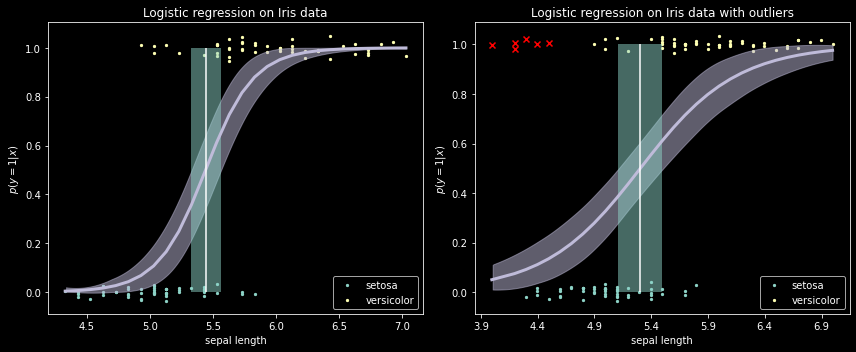

In [8]:
rng = np.random.default_rng()

def plot_training_data(x_c, y_0, x_mean, n_inliers, n_outliers, ax, rng=rng):
    inlier_ndx = np.arange(0, n_inliers)  # 0, ..., 99
    outlier_ndx = np.arange(n_inliers, n_inliers + n_outliers) # 100, ..., 105
    for c, label in enumerate(['setosa', 'versicolor']):
        ndx_c = np.where(y_0 == c)[0]
        sigma = 0.02  # for vertical jittering
        inliers = np.intersect1d(ndx_c, inlier_ndx)
        ax.scatter(x_c[inliers], rng.normal(y_0[inliers], sigma), s=5, c=f'C{c}', marker='o', label=label)
        outliers = np.intersect1d(ndx_c, outlier_ndx)
        ax.scatter(x_c[outliers], rng.normal(y_0[outliers], sigma), c='red', marker='x')
    # use original scale for xticks
    locs = ax.get_xticks()
    ax.set_xticks(locs, np.round(locs + x_mean, 1))
    ax.set_xlabel('sepal length')
    ax.set_ylabel('$p(y=1|x)$')
    ax.legend(loc='lower right')

def make_plot(posterior, x_c, ax):
    # plot logistic curve
    theta = posterior['θ']
    idx = np.argsort(x_c)
    ax.plot(x_c[idx], theta.mean(axis=(0, 1))[idx], color='C2', lw=3)
    az.plot_hdi(x_c, theta, color='C2', ax=ax)

    # plot decision boundary
    bd = posterior['bd']
    ax.vlines(bd.mean(), 0, 1)
    bd_hpd = az.hdi(bd)['bd']
    ax.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], alpha=0.5)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))

plot_training_data(x_inliers_c, y_inliers, x_inliers_mean, n_inliers, 0, ax1)
make_plot(trace_inliers['posterior'], x_inliers_c, ax1)
ax1.set_title("Logistic regression on Iris data")

plot_training_data(x_c, y_0, x_mean, n_inliers, n_outliers, ax2)
make_plot(trace_nonrobust['posterior'], x_c, ax2)
ax2.set_title("Logistic regression on Iris data with outliers")

fig.tight_layout()

#### Figure 10.10: (a) Logistic regression on some data with outliers (denoted by $\times$). Training points have been (vertically) jittered to avoid overlapping too much. Vertical line is the decision boundary, and its posterior credible interval. (b) same as (a) but using robust model, with a mixture likelihood.

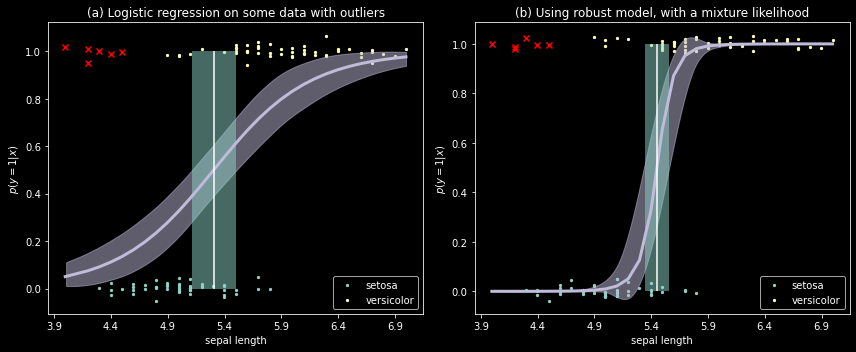

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))

plot_training_data(x_c, y_0, x_mean, n_inliers, n_outliers, ax1)
make_plot(trace_nonrobust['posterior'], x_c, ax1)
ax1.set_title("(a) Logistic regression on some data with outliers")

plot_training_data(x_c, y_0, x_mean, n_inliers, n_outliers, ax2)
make_plot(trace_robust['posterior'], x_c, ax2)
ax2.set_title("(b) Using robust model, with a mixture likelihood")

fig.tight_layout()